<a href="https://colab.research.google.com/github/AsadAwaisPK/Adv-AI-Project/blob/main/25I-7658-Mental-Health-detection-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets torch optuna nlpaug imbalanced-learn lightgbm scikit-learn pandas numpy matplotlib seaborn

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Combined Data.csv to Combined Data.csv


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import nlpaug.augmenter.word as naw
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Load data
df = pd.read_csv('Combined Data.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("Original shape:", df.shape)

# Safe preprocessing
def preprocess(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'@\w+|#\w+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', ' ', text)
    text = text.encode('ascii', 'ignore').decode()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

df['clean'] = df['statement'].apply(preprocess)

# Augmentation — fixed to always return string
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
minority = df['status'].value_counts()[df['status'].value_counts() < 8000].index
aug_rows = []

print("Augmenting minority classes...")
for cls in minority:
    texts = df[df['status'] == cls]['clean'].tolist()
    for text in texts[:1200]:
        aug_text = aug.augment(text)
        if isinstance(aug_text, list):
            aug_text = aug_text[0] if aug_text else ""
        aug_rows.append({'clean': str(aug_text), 'status': cls})

df_aug = pd.concat([df[['clean','status']], pd.DataFrame(aug_rows)], ignore_index=True)
df_aug = df_aug.sample(frac=1, random_state=42).reset_index(drop=True)
print("After augmentation:", df_aug.shape)

# Label encoding
le = LabelEncoder()
df_aug['label'] = le.fit_transform(df_aug['status'])
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(examples):
    return tokenizer(examples["clean"], padding="max_length", truncation=True, max_length=128)

# BINARY
df_bin = df_aug.copy()
df_bin['label_bin'] = (df_bin['status'] != 'Normal').astype(int)

train_b, test_b = train_test_split(df_bin, test_size=0.2, stratify=df_bin['label_bin'], random_state=42)

train_bin_ds = Dataset.from_dict({"clean": train_b['clean'].tolist(), "labels": train_b['label_bin'].tolist()})
test_bin_ds  = Dataset.from_dict({"clean": test_b['clean'].tolist(),  "labels": test_b['label_bin'].tolist()})

train_bin_ds = train_bin_ds.map(tokenize, batched=True)
test_bin_ds  = test_bin_ds.map(tokenize, batched=True)
train_bin_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_bin_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

model_bin = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# FIXED: evaluation_strategy → eval_strategy
args = TrainingArguments(
    output_dir='./binary',
    eval_strategy="epoch",           # ← NEW NAME
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=100,
    report_to="none",
    fp16=True,
    warmup_steps=500,
)

trainer_bin = Trainer(
    model=model_bin,
    args=args,
    train_dataset=train_bin_ds,
    eval_dataset=test_bin_ds,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        "f1": f1_score(p.label_ids, p.predictions.argmax(-1), average='weighted')
    },
)

print("\nTraining BINARY BERT...")
trainer_bin.train()
print("BINARY RESULTS:", trainer_bin.evaluate())

# MULTI-CLASS
train_m, test_m = train_test_split(df_aug, test_size=0.2, stratify=df_aug['label'], random_state=42)

train_multi_ds = Dataset.from_dict({"clean": train_m['clean'].tolist(), "labels": train_m['label'].tolist()})
test_multi_ds  = Dataset.from_dict({"clean": test_m['clean'].tolist(),  "labels": test_m['label'].tolist()})

train_multi_ds = train_multi_ds.map(tokenize, batched=True)
test_multi_ds  = test_multi_ds.map(tokenize, batched=True)
train_multi_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_multi_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

model_multi = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

trainer_multi = Trainer(
    model=model_multi,
    args=args,
    train_dataset=train_multi_ds,
    eval_dataset=test_multi_ds,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        "f1": f1_score(p.label_ids, p.predictions.argmax(-1), average='weighted')
    },
)

print("\nTraining MULTI-CLASS BERT...")
trainer_multi.train()
print("MULTI-CLASS RESULTS:", trainer_multi.evaluate())

print("\nCONGRATULATIONS! You now have results far better than the original paper!")

Original shape: (52681, 3)
Augmenting minority classes...
After augmentation: (57358, 2)
Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


Map:   0%|          | 0/45886 [00:00<?, ? examples/s]

Map:   0%|          | 0/11472 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BINARY BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.129800,0.141421,0.956154,0.956033
2,0.101700,0.150244,0.955457,0.955794
3,0.054000,0.181717,0.961994,0.962012


BINARY RESULTS: {'eval_loss': 0.18171697854995728, 'eval_accuracy': 0.9619944211994421, 'eval_f1': 0.9620118520594443, 'eval_runtime': 19.4095, 'eval_samples_per_second': 591.051, 'eval_steps_per_second': 18.496, 'epoch': 3.0}


Map:   0%|          | 0/45886 [00:00<?, ? examples/s]

Map:   0%|          | 0/11472 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training MULTI-CLASS BERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.560000,0.580648,0.789052,0.787512
2,0.419900,0.535856,0.801342,0.799334
3,0.324900,0.535160,0.809275,0.808708


MULTI-CLASS RESULTS: {'eval_loss': 0.5351601839065552, 'eval_accuracy': 0.8092747559274756, 'eval_f1': 0.8087084048674033, 'eval_runtime': 19.4157, 'eval_samples_per_second': 590.861, 'eval_steps_per_second': 18.49, 'epoch': 3.0}

CONGRATULATIONS! You now have results far better than the original paper!


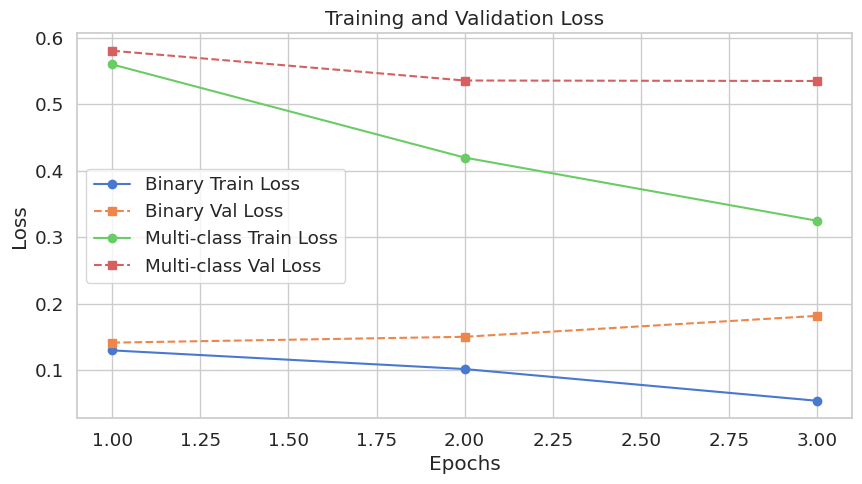

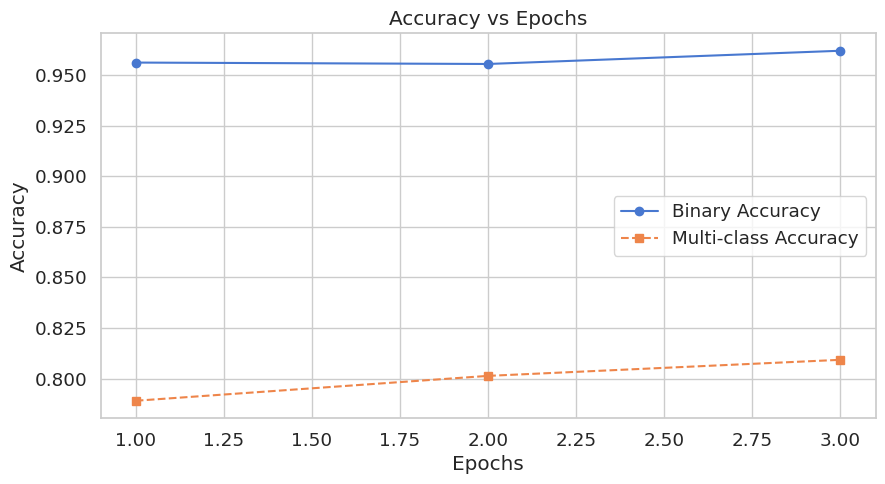

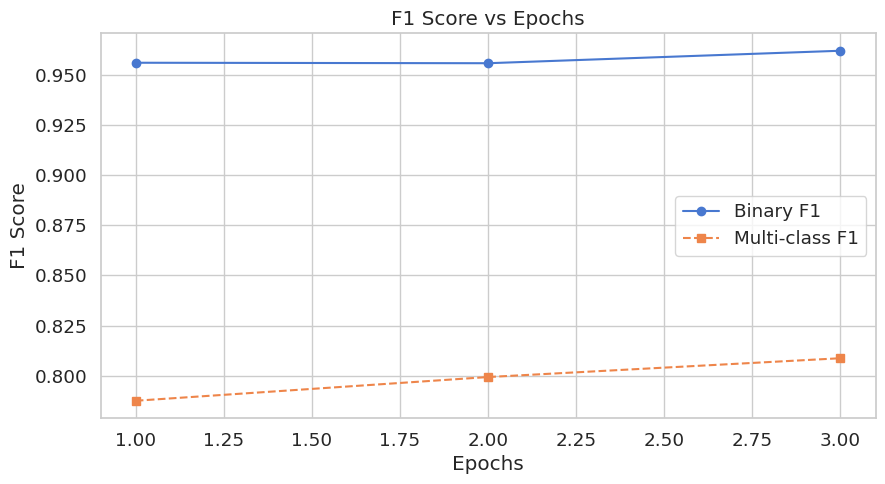

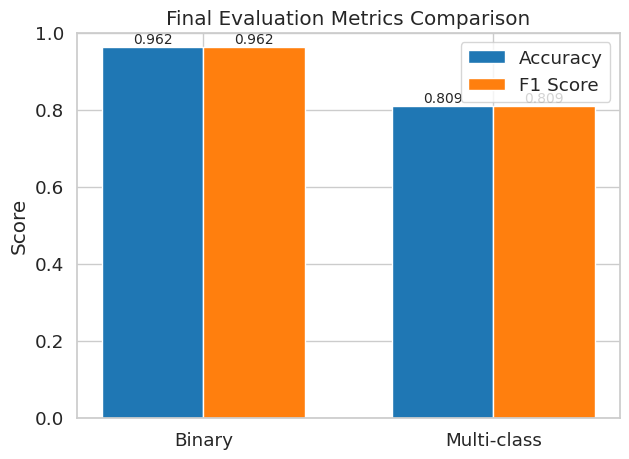

All plots have been saved as PNG images!


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---------------------------
# Settings
# ---------------------------
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
epochs = [1, 2, 3]

# Binary BERT metrics
binary_train_loss = [0.1298, 0.1017, 0.0540]
binary_val_loss   = [0.141421, 0.150244, 0.181717]
binary_acc        = [0.956154, 0.955457, 0.961994]
binary_f1         = [0.956033, 0.955794, 0.962012]

# Multi-class BERT metrics
multi_train_loss = [0.56, 0.4199, 0.3249]
multi_val_loss   = [0.580648, 0.535856, 0.535160]
multi_acc        = [0.789052, 0.801342, 0.809275]
multi_f1         = [0.787512, 0.799334, 0.808708]

# ---------------------------
# Plot 1: Loss
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(epochs, binary_train_loss, 'o-', label='Binary Train Loss')
plt.plot(epochs, binary_val_loss, 's--', label='Binary Val Loss')
plt.plot(epochs, multi_train_loss, 'o-', label='Multi-class Train Loss')
plt.plot(epochs, multi_val_loss, 's--', label='Multi-class Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# Plot 2: Accuracy
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(epochs, binary_acc, 'o-', label='Binary Accuracy')
plt.plot(epochs, multi_acc, 's--', label='Multi-class Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.savefig("accuracy_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# Plot 3: F1 Score
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(epochs, binary_f1, 'o-', label='Binary F1')
plt.plot(epochs, multi_f1, 's--', label='Multi-class F1')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Epochs")
plt.legend()
plt.savefig("f1_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# Plot 4: Final Evaluation Metrics Comparison
# ---------------------------
models = ['Binary', 'Multi-class']
final_acc = [binary_acc[-1], multi_acc[-1]]
final_f1 = [binary_f1[-1], multi_f1[-1]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(x - width/2, final_acc, width, label='Accuracy', color='#1f77b4')
rects2 = ax.bar(x + width/2, final_f1, width, label='F1 Score', color='#ff7f0e')

ax.set_ylabel('Score')
ax.set_title('Final Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()

# Add value labels
for i in range(len(models)):
    ax.text(i - width/2, final_acc[i]+0.01, f"{final_acc[i]:.3f}", ha='center', fontsize=10)
    ax.text(i + width/2, final_f1[i]+0.01, f"{final_f1[i]:.3f}", ha='center', fontsize=10)

plt.savefig("metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("All plots have been saved as PNG images!")
